<a href="https://colab.research.google.com/github/chwonghk01/typo-detection/blob/master/rnn_typo_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --upgrade pyarrow
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText && pip install .

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.6/dist-packages (0.11.1)
fatal: destination path 'fastText' already exists and is not an empty directory.
Processing /content/fastText
  Running setup.py bdist_wheel for fasttext ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-_1hgyi82/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
  Found existing installation: fasttext 0.8.22
    Uninstalling fasttext-0.8.22:
      Successfully uninstalled fasttext-0.8.22


In [5]:
!wget https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
!unzip -o simhei.zip
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.zh_classical.zip
!unzip -o wiki.zh_classical.zip

--2019-01-08 06:34:03--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip.1’

simhei.zip.1        100%[===================>]  10.06M  8.82MB/s    in 1.1s    

2019-01-08 06:34:05 (8.82 MB/s) - ‘simhei.zip.1’ saved [10546298/10546298]

Archive:  simhei.zip
replace chinese.simhei.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
--2019-01-08 06:34:20--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.zh_classical.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.73
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2253991999 (2.1G) [application/zip]
Saving to: ‘wiki.zh_clas

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [7]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import numpy as np
import fastText

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [8]:
df = pd.read_parquet('/gdrive/My Drive/typo-detection/article_contents.snappy.parquet')[['article_id', 'main_content']].set_index('article_id')
df = df[~df.main_content.isnull()]
df.head()

,main_content
article_id,
3,英超曼聯今晨主場出擊，只能與剛剛上任為車路士的領隊軒迪克打和0:0，近8場未嘗勝績，備受批評...
6,港超勁旅南華宣布羅致前厄瓜多爾國腳菲力斯保耶（Felix Borja），簽約一年半；足主張廣...
7,阿仙奴走出日前慘吞修咸頓4球的陰影，今晨主場憑奧斯爾一傳一射，以2：0氣走般尼茅夫，以19戰...
9,英超今晨其餘賽事，熱刺憑前鋒孫興愍89分鐘的入球，以２：1作客反勝屈福特，暫時升上聯賽榜第3...
10,352場英超上陣，170場不失球，令阿仙奴門將施治打破前英格蘭國腳占士紀錄，成為英超史上不失...


In [9]:
# Train test split articles
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train, val, = train_test_split(train, test_size=0.2, shuffle=False)
train.shape, val.shape, test.shape

((174664, 1), (43667, 1))

In [10]:
TRAIN_SIZE = -1
TEST_SIZE = -1

# Run tokenizer on char level for training data, support 100k + tokens, with oov token (from keras)
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, oov_token='<oov>', split='')
tokenizer.fit_on_texts(train[:TRAIN_SIZE].main_content)
len(tokenizer.index_word), tokenizer.word_index['<oov>']

(12496, 1)

In [0]:
# Split article to 64 chars each for both training and testing
# Keras Articles -> Chars -> Indices -> Pad to 64 chars

SEQ_LENGTH = 128 #@param {type:"integer"}

# def generate_dataset(df, error_prob):
#   seqs = tokenizer.texts_to_sequences(df.main_content)
#   padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=SEQ_LENGTH, padding='post', truncating='post', value=0.0)
  
#   index_word_count = [(tokenizer.word_index[k], v) for k, v in tokenizer.word_counts.items()]
#   index_word_count.append((0, sum([x[1] for x in index_word_count]) / (error_prob) * (1 - error_prob)))
  
#   choice = np.array([x[0] for x in index_word_count])

#   p = np.array([x[1] for x in index_word_count])
#   p = p / np.sum(p)
  
#   # for each sequence, randomly replace the index
#   random_error = np.random.choice(choice, padded_seqs.shape, p=p)
#   random_error_mask = (random_error > 0).astype(int)
  
#   inp = padded_seqs * (1-random_error_mask) + random_error
#   out = random_error_mask
  
#   return inp, out


# TODO: fully utilize corpus insteads of only first 32 tokens
def dataset_generator(corpus, mask_prob=0.15, mask_error_prob=0.8, batch_size=64, seed=42):
  seqs = tokenizer.texts_to_sequences(corpus)
  
  def chunk(list_of_list, chunk_size): 
    result = []
    for l in list_of_list:
      for i in range(len(l) // chunk_size):
        result.append(l[i*chunk_size:i*chunk_size+chunk_size])

    return result
  
  seqs = chunk(seqs, chunk_size=SEQ_LENGTH)
  padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=SEQ_LENGTH, padding='post', truncating='post', value=0.0)
  
  # Create FIXED mask for each full dataset
  masks = np.random.choice([0., 1.,], padded_seqs.shape, p=np.array([1-mask_prob, mask_prob]))
  
  # Word choice by count frequency
  index_word_count = [(tokenizer.word_index[k], v) for k, v in tokenizer.word_counts.items()]
  choice = np.array([x[0] for x in index_word_count])
  p = np.array([x[1] for x in index_word_count])
  p = p / np.sum(p)

  
  # Uniformly random sample a batch of (padded_seq, mask)
  while True:
    idx = np.random.randint(padded_seqs.shape[0], size=batch_size)
    inp = padded_seqs[idx]
    out = masks[idx]
    
    # replace each masked token by 1-mask_error_prob the original word, mask_error_prob a randomly sampled word
    out = out * np.random.choice([0., 1.,], out.shape, p=np.array([1-mask_error_prob, mask_error_prob]))
    
    random_error = np.random.choice(choice, inp.shape, p=p)
    inp = inp * (1-out) + random_error * out
    
    yield (inp, out)

In [0]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import seaborn as sns

def visualize(inp, truth, pred=None, display_rows=5):
  font_files = font_manager.findSystemFonts(fontpaths='/content')
  font_list = font_manager.createFontList(font_files)
  font_manager.fontManager.ttflist.extend(font_list)
  sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

  fig, ax = plt.subplots(figsize=(24 * SEQ_LENGTH // 64,display_rows / 3))
  sns.heatmap(truth[:display_rows], \
    annot=np.array([[c for c in row[::2]] for row in tokenizer.sequences_to_texts(inp)[:display_rows]]), \
    fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)
  
  if pred is not None:
    fig, ax = plt.subplots(figsize=(24 * SEQ_LENGTH // 64,display_rows / 3))
    sns.heatmap(pred[:display_rows], \
      annot=np.array([[c for c in row[::2]] for row in tokenizer.sequences_to_texts(inp)[:display_rows]]), \
      fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)


In [0]:
# tokenizer.index_word
# ft = fastText.load_model('./wiki.zh_classical.bin')

# FT_EMB_SIZE = 300

# fasttext_emb = np.zeros((len(tokenizer.index_word) + 1, FT_EMB_SIZE))
# for idx, word in tokenizer.index_word.items():
#   fasttext_emb[idx] = ft.get_word_vector(word)
  
# fasttext_emb[:5]

In [14]:
EMBEDDING_SIZE = 256 #@param {type:"number"}
GRU_SIZE = EMBEDDING_SIZE // 2
L2_REG = 0 #@param {type:"number"}
  
def build_model():
#   model = models.Sequential()
  inp = layers.Input((SEQ_LENGTH,), dtype='int32')
  emb = layers.Embedding(
      len(tokenizer.index_word) + 1, 
      EMBEDDING_SIZE,
      input_length=SEQ_LENGTH,
      embeddings_regularizer = tf.keras.regularizers.l2(l=L2_REG)
  )(inp)
  
#   ft_emb = layers.Embedding(len(tokenizer.index_word) + 1, FT_EMB_SIZE, weights=[fasttext_emb], trainable=False, input_length=SEQ_LENGTH)(inp)

  emb_input = emb
#   emb_input = layers.Concatenate()([emb, ft_emb])
  
  gru = layers.Bidirectional(layers.CuDNNGRU(GRU_SIZE, return_sequences=True))(emb_input)
  gru = layers.Bidirectional(layers.CuDNNGRU(GRU_SIZE, return_sequences=True))(gru)
  
#   final = gru
  final = layers.Add()([gru, emb])
#   gru = layers.CuDNNGRU(GRU_SIZE, return_sequences=True)(gru)
  
  pred = layers.Dense(1, activation='sigmoid')(final)
  out = layers.Flatten()(pred)
  
  model = models.Model(inputs=inp, outputs=out)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae', 'acc'])
  return model
  
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 256)     3199232     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 256)     296448      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 256)     296448      bidirectional[0][0]              
__________________________________________________________________________________________________
add (Add) 

In [0]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import Callback

class metrics(Callback):
    def __init__(self, validation_data):
#         self.x = training_data[0]
#         self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
#         y_pred = self.model.predict(self.x)
#         roc = roc_auc_score(self.y, y_pred)
#         prec = precision_score(np.ndarray.flatten((self.y).astype(int)), np.ndarray.flatten((y_pred > 0.5).astype(int)))
#         recall = recall_score(np.ndarray.flatten((self.y).astype(int)), np.ndarray.flatten((y_pred > 0.5).astype(int)))
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
      
        prec_val = precision_score(np.ndarray.flatten((self.y_val).astype(int)), np.ndarray.flatten((y_pred_val > 0.5).astype(int)))
        recall_val = recall_score(np.ndarray.flatten((self.y_val).astype(int)), np.ndarray.flatten((y_pred_val > 0.5).astype(int)))
        f1_val = f1_score(np.ndarray.flatten((self.y_val).astype(int)), np.ndarray.flatten((y_pred_val > 0.5).astype(int)))
        
        print('\rroc-auc_val: %s' % (str(round(roc_val,4))),end=100*' '+'\n')
        print('\rprecision_val: %s' % (str(round(prec_val,4))),end=100*' '+'\n')
        print('\rrecall_val: %s' % (str(round(recall_val,4))),end=100*' '+'\n')
        print('\rf1_val: %s' % (str(round(f1_val,4))),end=100*' '+'\n')
        
#         print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
#         print('\rprecision: %s - precision_val: %s' % (str(round(prec,4)),str(round(prec_val,4))),end=100*' '+'\n')
#         print('\rrecall: %s - recall_val: %s' % (str(round(recall,4)),str(round(recall_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [0]:
# train_inp.shape, train_out.shape


# model.fit( \
#           X_train, \
#           y_train, \
#           validation_data=(X_val, y_val),
#           batch_size=64, \
#           epochs=1000, \
#           callbacks=[metrics(training_data=(X_train, y_train), validation_data=(X_val, y_val))],
#          )


from tensorflow.keras.callbacks import ModelCheckpoint

MASK_PROB = 0.15 #@param {type:"number"}
MASK_ERROR_PROB = 0.8 #@param {type:"number"}
BATCH_SIZE = 64 #@param {type:"number"}

VAL_MASK_PROB = 0.01 #@param {type:"number"}
VAL_MASK_ERROR_PROB = 1. #@param {type:"number"}


tr, val = train_test_split(train[:TRAIN_SIZE], test_size=0.2, shuffle=False)

train_gen = dataset_generator(tr.main_content, MASK_PROB, MASK_ERROR_PROB, batch_size=BATCH_SIZE)
X_val, y_val = next(dataset_generator(val.main_content, VAL_MASK_PROB, VAL_MASK_ERROR_PROB, batch_size=BATCH_SIZE * 1000))

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

model.fit_generator( \
    train_gen, \
    steps_per_epoch = 1000, \
    validation_data=(X_val, y_val), \
    callbacks=[metrics(validation_data=(X_val, y_val)), checkpoint], \
    epochs=10000
)

Epoch 1/10000
roc-auc_val: 0.9783                                                                                                    
precision_val: 0.3835                                                                                                    
recall_val: 0.7583                                                                                                    
f1_val: 0.5093                                                                                                    

Epoch 00001: val_loss improved from inf to 0.04843, saving model to best_model.h5
1000/1000 [==============================] - 264s 264ms/step - loss: 0.1411 - mean_absolute_error: 0.0822 - acc: 0.9444 - val_loss: 0.0484 - val_mean_absolute_error: 0.0351 - val_acc: 0.9854
Epoch 2/10000
roc-auc_val: 0.9786                                                                                                    
precision_val: 0.4144                                                                                 

In [24]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'data-poc-227904'
!gcloud config set project {project_id}



!gsutil cp 021.h5 gs://hk01dev-typo-detection/rnn/model/021.h5

Updated property [core/project].
Copying file://021.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/43.5 MiB.                                     


In [56]:
best_model = tf.keras.models.load_model('021.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [57]:
X_val, y_val
pred_val = best_model.predict(X_val)
pred_val

array([[4.6304651e-02, 4.6192278e-04, 7.0234383e-03, ..., 2.3344932e-02,
        2.0534228e-01, 7.0893586e-02],
       [7.0963847e-03, 1.5868072e-03, 4.3780673e-03, ..., 6.3231654e-02,
        2.8629936e-02, 1.3229539e-01],
       [1.1199492e-02, 2.2301391e-04, 1.4263584e-03, ..., 2.2879983e-03,
        9.7427820e-04, 3.0809473e-02],
       ...,
       [9.1199827e-04, 1.3656319e-03, 1.6302570e-03, ..., 3.0073503e-01,
        5.8434403e-01, 1.5235135e-01],
       [1.6007502e-01, 1.1554293e-02, 1.0115958e-02, ..., 1.7033944e-02,
        1.5114379e-02, 1.3203903e-02],
       [5.1235589e-03, 5.4958770e-03, 6.3081384e-03, ..., 1.6628973e-03,
        9.5272949e-03, 5.1728811e-02]], dtype=float32)

In [0]:
truths = y_val
preds = pred_val

from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score

precision, recall, thresholds = precision_recall_curve(truths.flatten(), preds.flatten())

roc = roc_auc_score(truths, preds)

In [59]:
roc

0.9764592123009321

(0.0, 1.0)

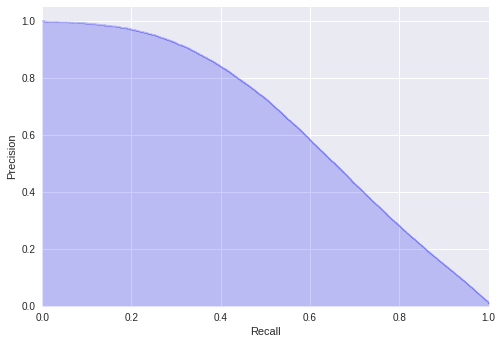

In [60]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))

In [62]:
f1 = []
precision = []
recall = []
threshold = np.linspace(0,1,11)
for i in threshold:
  print(i)
  y_true = truths.astype(int).flatten()
#   print(y_true.shape)
#   print(np.min(y_true), max(np.min(y_true)))
  y_pred = (preds >= i).astype(int).flatten()
#   print(y_pred.shape)
#   print(min(y_pred), max(y_pred))
  f1.append(f1_score(y_true, y_pred))
#   print()
  precision.append(precision_score(y_true, y_pred))
  recall.append(recall_score(y_true, y_pred))

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
pd.DataFrame({ 'f1':f1, 'p': precision, 'r': recall, 't':threshold})

,f1,p,r,t
0,0.019756,0.009977,1.000000,0.0
1,0.209668,0.118300,0.920971,0.1
2,0.312401,0.190617,0.865127,0.2
3,0.396242,0.261934,0.813224,0.3
4,0.466767,0.336433,0.761945,0.4
5,0.524693,0.416603,0.708525,0.5
6,0.569048,0.505176,0.651409,0.6
7,0.594697,0.601774,0.587784,0.7
8,0.595358,0.712255,0.511422,0.8
9,0.546524,0.833798,0.406478,0.9


In [0]:
np.argmax(f1)

In [0]:
# from keras import backend as K                                                                                                               
import tensorflow as tf
                                                                                                                                             
signature = tf.saved_model.signature_def_utils.predict_signature_def(                                                                        
    inputs={'image': model.input}, outputs={'scores': model.output})                                                                         
                                                                                                                                             
builder = tf.saved_model.builder.SavedModelBuilder('/tmp/my_saved_model')                                                                    
builder.add_meta_graph_and_variables(                                                                                                        
    sess=K.get_session(),                                                                                                                    
    tags=[tf.saved_model.tag_constants.SERVING],                                                                                             
    signature_def_map={                                                                                                                      
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:                                                                
            signature                                                                                                                        
    })                                                                                                                                       
builder.save()

In [0]:
test_gen = dataset_generator(test[:1].main_content, MASK_PROB, MASK_ERROR_PROB, batch_size=BATCH_SIZE)

In [0]:
test_inp, test_out = next(test_gen)
test_pred = model.predict(test_inp)

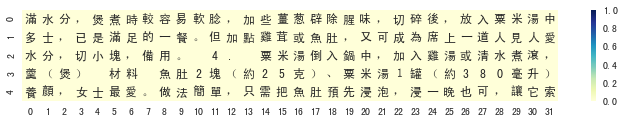

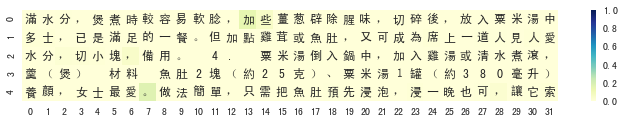

In [16]:
visualize(test_inp, test_out, test_pred)

In [0]:
raw_test_gen = dataset_generator(test[:50].main_content, mask_prob=0., mask_error_prob=0., batch_size=BATCH_SIZE)

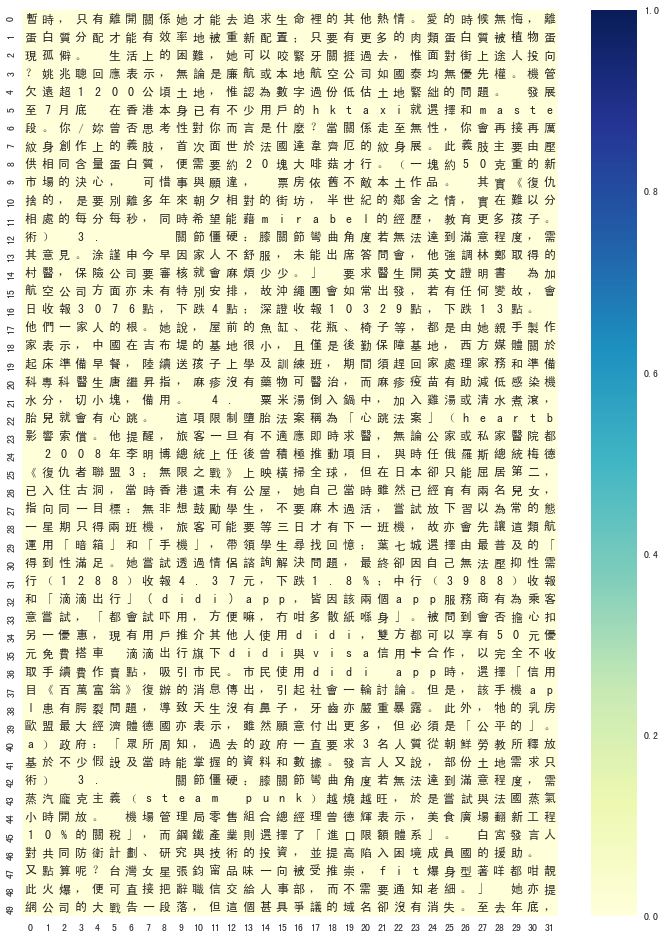

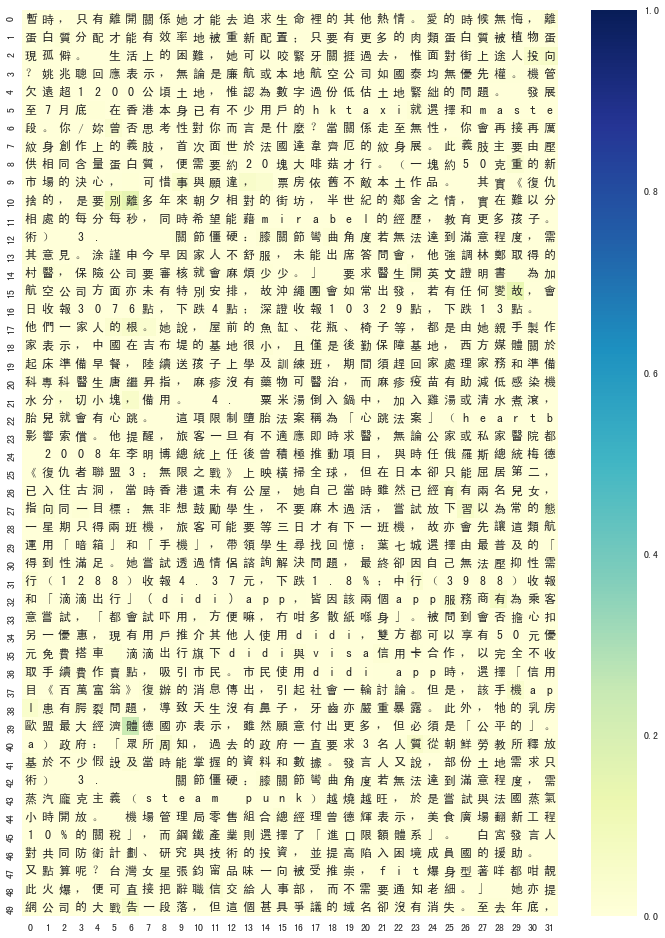

In [31]:
raw_test_inp, raw_test_out = next(raw_test_gen)
raw_test_pred = model.predict(raw_test_inp)

visualize(raw_test_inp, raw_test_out, raw_test_pred, display_rows=50)

In [0]:
# Improvement
# Better corpus
# Masked Loss Function (?)
# Pretrainined Word Vector (done)
# Better Typo Models
# Tune precision threshold
# Concat Char Level pretrainined word vectors
# Dropout and Regularization
# Random error probability per sentence